Rick Images Generator

In [ ]:
import os
import random
import torch
import torch.nn as nn
import torch.nn.parallel
import torch.optim as optim
import torch.utils.data
import torchvision.datasets as dset
import torchvision.transforms as transforms
import torchvision.utils as vutils
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from IPython.display import HTML


Note: you may need to restart the kernel to use updated packages.


In [ ]:
dataPath = "data_edited/"  # Data directory

workers = 2                 # Dataloader workers
batch_size = 128           # Training batch size
image_size = 256           # Image resize size

channel_num = 3            # Image channels (3 for RGB)
gen_input_size = 100       # Latent vector size (GeneratorModel input)
feature_size_gen = 64      # GeneratorModel feature map size
feature_size_dis = 64      # Discriminator feature map size

num_epochs = 50            # Training epochs
lr = 0.0002                # Optimizer learning rate
beta1 = 0.5                # Adam optimizer beta1
ngpu = 1                   # Number of GPUs (0 = CPU)

Using device: cpu


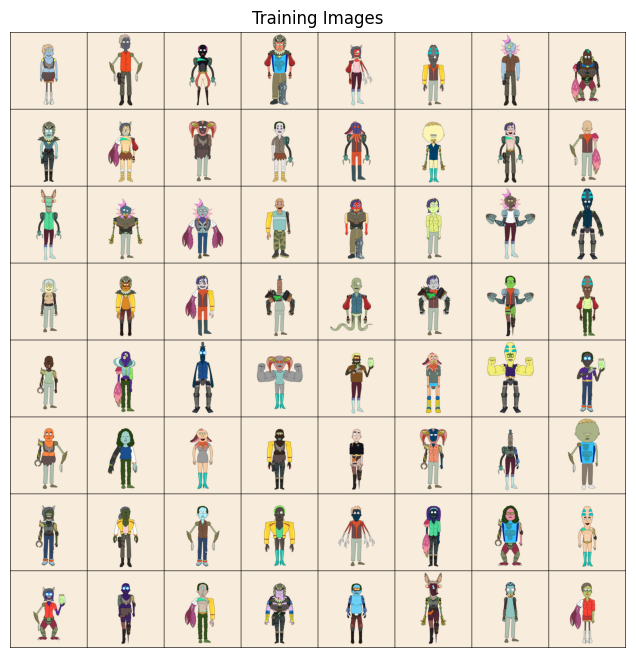

In [ ]:
dataset = dset.ImageFolder(root=dataPath,
    transform=transforms.Compose([
        transforms.Resize(image_size),
        transforms.CenterCrop(image_size),
        transforms.ToTensor(),
        transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
]))

dataloader = torch.utils.data.DataLoader(dataset, batch_size=batch_size,shuffle=True, num_workers=workers)


device = torch.device("cuda:0" if (torch.cuda.is_available() and ngpu > 0) else "cpu")
print("Using device:", device)

# Plot some training images
init_batch = next(iter(dataloader))
plt.figure(figsize=(8,8))
plt.axis("off")
plt.title("Training Images")
plt.imshow(np.transpose(vutils.make_grid(init_batch[0].to(device)[:64], padding=2, normalize=True).cpu(),(1,2,0)))
plt.show()

In [ ]:
def weights_init(layer):
    layer_type = layer.__class__.__name__
    if 'Conv' in layer_type:
        nn.init.normal_(layer.weight.data, 0.0, 0.02)
    elif 'BatchNorm' in layer_type:
        nn.init.normal_(layer.weight.data, 1.0, 0.02)
        nn.init.constant_(layer.bias.data, 0)


class GeneratorModel(nn.Module):
    def __init__(self, num_gpus):
        super().__init__()
        self.num_gpus = num_gpus
        f = feature_size_gen
        z = gen_input_size
        c = channel_num

        self.network = nn.Sequential(
            nn.ConvTranspose2d(z, f * 8, 4, 1, 0, bias=False),
            nn.BatchNorm2d(f * 8),
            nn.ReLU(True),

            nn.ConvTranspose2d(f * 8, f * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(f * 4),
            nn.ReLU(True),

            nn.ConvTranspose2d(f * 4, f * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(f * 2),
            nn.ReLU(True),

            nn.ConvTranspose2d(f * 2, f, 4, 2, 1, bias=False),
            nn.BatchNorm2d(f),
            nn.ReLU(True),

            nn.ConvTranspose2d(f, f // 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(f // 2),
            nn.ReLU(True),

            nn.ConvTranspose2d(f // 2, f // 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(f // 4),
            nn.ReLU(True),

            nn.ConvTranspose2d(f // 4, c, 4, 2, 1, bias=False),
            nn.Tanh()
        )

    def forward(self, z_input):
        return self.network(z_input)


In [ ]:
# Create the GeneratorModel
netG = GeneratorModel(ngpu).to(device)

# Handle multi-GPU if desired
if (device.type == 'cuda') and (ngpu > 1):
    netG = nn.DataParallel(netG, list(range(ngpu)))

# Apply the ``weights_init`` function to randomly initialize all weights
#  to ``mean=0``, ``stdev=0.02``.
netG.apply(weights_init)

# Print the model
print(netG)

Generator(
  (main): Sequential(
    (0): ConvTranspose2d(100, 512, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): ConvTranspose2d(512, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (4): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): ConvTranspose2d(256, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (7): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): ReLU(inplace=True)
    (9): ConvTranspose2d(128, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (10): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (11): ReLU(inplace=True)
    (12): ConvTranspose2d(64, 32, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (13): BatchNorm2d(

In [ ]:
class DiscriminatorModel(nn.Module):
    def __init__(self, num_gpus):
        super().__init__()
        self.num_gpus = num_gpus
        c = channel_num
        f = feature_size_dis

        self.network = nn.Sequential(
            nn.Conv2d(c, f // 4, kernel_size=4, stride=2, padding=1, bias=False),  # 256x256 -> 128x128
            nn.LeakyReLU(0.2, inplace=True),

            nn.Conv2d(f // 4, f // 2, 4, 2, 1, bias=False),                         # 128x128 -> 64x64
            nn.BatchNorm2d(f // 2),
            nn.LeakyReLU(0.2, inplace=True),

            nn.Conv2d(f // 2, f, 4, 2, 1, bias=False),                              # 64x64 -> 32x32
            nn.BatchNorm2d(f),
            nn.LeakyReLU(0.2, inplace=True),

            nn.Conv2d(f, f * 2, 4, 2, 1, bias=False),                               # 32x32 -> 16x16
            nn.BatchNorm2d(f * 2),
            nn.LeakyReLU(0.2, inplace=True),

            nn.Conv2d(f * 2, f * 4, 4, 2, 1, bias=False),                           # 16x16 -> 8x8
            nn.BatchNorm2d(f * 4),
            nn.LeakyReLU(0.2, inplace=True),

            nn.Conv2d(f * 4, f * 8, 4, 2, 1, bias=False),                           # 8x8 -> 4x4
            nn.BatchNorm2d(f * 8),
            nn.LeakyReLU(0.2, inplace=True),

            nn.Conv2d(f * 8, 1, 4, 1, 0, bias=False),                               # 4x4 -> 1x1
            nn.Sigmoid()
        )

    def forward(self, x):
        return self.network(x)


In [ ]:
# Initialize discriminator model
discriminator = DiscriminatorModel(ngpu).to(device)

# Enable multi-GPU setup if available
if device.type == 'cuda' and ngpu > 1:
    discriminator = nn.DataParallel(discriminator, device_ids=list(range(ngpu)))

# Initialize model weights (mean=0.0, std=0.02)
discriminator.apply(weights_init)

# Display architecture
print(discriminator)


Discriminator(
  (main): Sequential(
    (0): Conv2d(3, 16, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): LeakyReLU(negative_slope=0.2, inplace=True)
    (2): Conv2d(16, 32, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (3): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (4): LeakyReLU(negative_slope=0.2, inplace=True)
    (5): Conv2d(32, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (6): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): LeakyReLU(negative_slope=0.2, inplace=True)
    (8): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (9): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): LeakyReLU(negative_slope=0.2, inplace=True)
    (11): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (12): BatchNorm2d(256, eps=1e-05, moment

In [ ]:
# Binary cross-entropy loss for real vs. fake classification
loss_function = nn.BCELoss()

# Latent vectors for tracking generator output over time
sample_noise = torch.randn(64, gen_input_size, 1, 1, device=device)

# Labels used for real and fake data
label_real = 1.0
label_fake = 0.0

# Optimizers for discriminator and generator
optimizer_D = optim.Adam(discriminator.parameters(), lr=lr, betas=(beta1, 0.999))
optimizer_G = optim.Adam(netG.parameters(), lr=lr, betas=(beta1, 0.999))


In [ ]:
# Tracking metrics
generated_images = []
loss_history_G = []
loss_history_D = []
iteration = 0

print("Beginning training process...")

for epoch in range(num_epochs):
    for step, batch in enumerate(dataloader):

        # === Discriminator training: Real samples ===
        discriminator.zero_grad()
        real_images = batch[0].to(device)
        current_batch_size = real_images.size(0)
        labels_real = torch.full((current_batch_size,), label_real, dtype=torch.float, device=device)

        pred_real = discriminator(real_images).view(-1)
        loss_real = loss_function(pred_real, labels_real)
        loss_real.backward()
        D_real_score = pred_real.mean().item()

        # === Discriminator training: Fake samples ===
        random_noise = torch.randn(current_batch_size, gen_input_size, 1, 1, device=device)
        fake_images = netG(random_noise)
        labels_fake = torch.full((current_batch_size,), label_fake, dtype=torch.float, device=device)

        pred_fake = discriminator(fake_images.detach()).view(-1)
        loss_fake = loss_function(pred_fake, labels_fake)
        loss_fake.backward()
        D_fake_score = pred_fake.mean().item()

        # Combine real and fake losses
        total_D_loss = loss_real + loss_fake
        optimizer_D.step()

        # === Generator training ===
        netG.zero_grad()
        labels_real.fill_(label_real)  # Generator tries to trick D as if fakes were real

        pred_for_G = discriminator(fake_images).view(-1)
        G_loss = loss_function(pred_for_G, labels_real)
        G_loss.backward()
        G_score = pred_for_G.mean().item()
        optimizer_G.step()

        # Logging
        if step % 50 == 0:
            print(f"[{epoch}/{num_epochs}][{step}/{len(dataloader)}]\t"
                  f"D_loss: {total_D_loss.item():.4f}\tG_loss: {G_loss.item():.4f}\t"
                  f"D(x): {D_real_score:.4f}\tD(G(z)): {D_fake_score:.4f} / {G_score:.4f}")

        # Store losses for visualization
        loss_history_G.append(G_loss.item())
        loss_history_D.append(total_D_loss.item())

        # Generate preview images periodically
        if (iteration % 500 == 0) or (epoch == num_epochs - 1 and step == len(dataloader) - 1):
            with torch.no_grad():
                preview_fake = netG(sample_noise).detach().cpu()
            grid = vutils.make_grid(preview_fake, padding=2, normalize=True)
            generated_images.append(grid)

        iteration += 1

# Save model
os.makedirs("models", exist_ok=True)
save_path = "models/rickGeneratorModelModel.pth"
torch.save(netG.state_dict(), save_path)
print("Model successfully saved at:", save_path)


Starting Training Loop...
[0/50][0/79]	Loss_D: 1.2214	Loss_G: 4.9005	D(x): 0.6574	D(G(z)): 0.4729 / 0.0109
[0/50][50/79]	Loss_D: 0.0001	Loss_G: 42.5423	D(x): 0.9999	D(G(z)): 0.0000 / 0.0000
[1/50][0/79]	Loss_D: 0.0003	Loss_G: 42.2868	D(x): 0.9997	D(G(z)): 0.0000 / 0.0000
[1/50][50/79]	Loss_D: 0.0000	Loss_G: 42.1272	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000
[2/50][0/79]	Loss_D: 0.0000	Loss_G: 42.1136	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000
[2/50][50/79]	Loss_D: 0.0001	Loss_G: 41.9978	D(x): 0.9999	D(G(z)): 0.0000 / 0.0000
[3/50][0/79]	Loss_D: 0.0000	Loss_G: 41.9850	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000
[3/50][50/79]	Loss_D: 0.0000	Loss_G: 42.0321	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000
[4/50][0/79]	Loss_D: 0.0000	Loss_G: 41.9470	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000
[4/50][50/79]	Loss_D: 0.0000	Loss_G: 41.8949	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000
[5/50][0/79]	Loss_D: 0.0000	Loss_G: 41.9673	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000
[5/50][50/79]	Loss_D: 0.0000	Loss_G: 41.8550	D(x): 1.0000	D(G(z)): 0

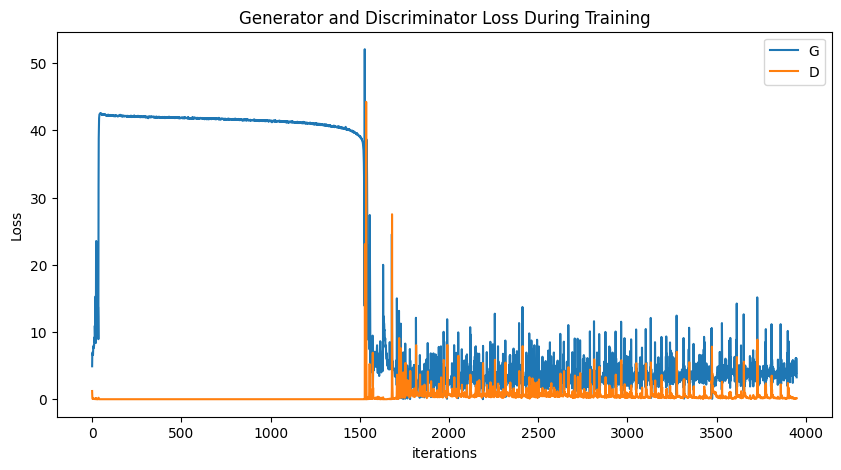

In [ ]:
plt.figure(figsize=(10,5))
plt.title("GeneratorModel and Discriminator Loss During Training")
plt.plot(loss_history_G,label="G")
plt.plot(loss_history_D,label="D")
plt.xlabel("iterations")
plt.ylabel("Loss")
plt.legend()
plt.show()

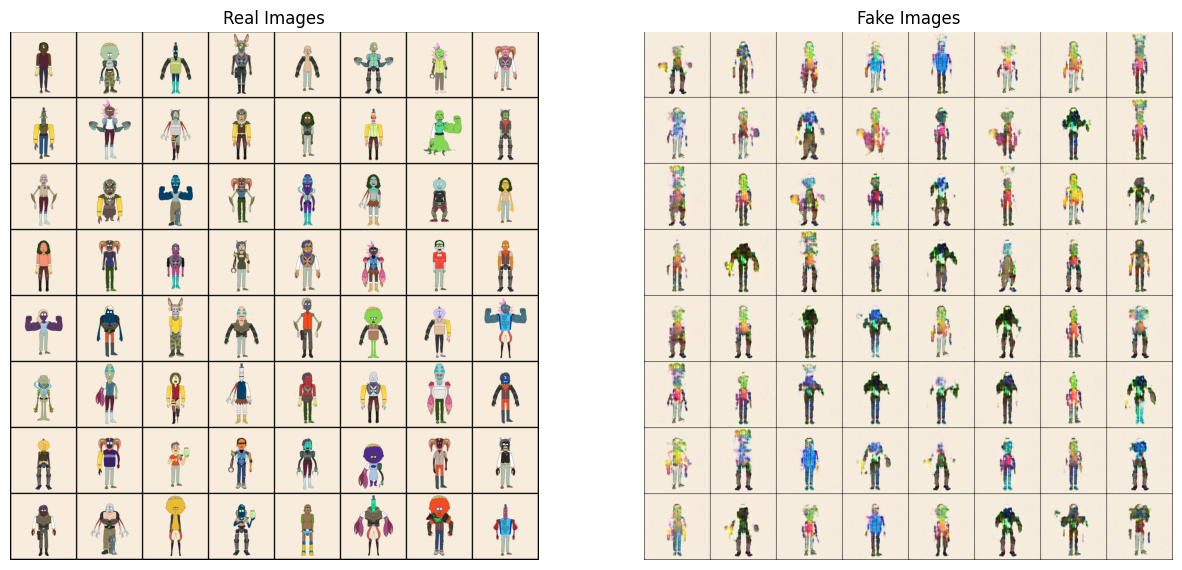

In [ ]:
# Grab a batch of real images from the dataloader
init_batch = next(iter(dataloader))

# Plot the real images
plt.figure(figsize=(15,15))
plt.subplot(1,2,1)
plt.axis("off")
plt.title("Real Images")
plt.imshow(np.transpose(vutils.make_grid(init_batch[0].to(device)[:64], padding=5, normalize=True).cpu(),(1,2,0)))

# Plot the fake images from the last epoch
plt.subplot(1,2,2)
plt.axis("off")
plt.title("Fake Images")
plt.imshow(np.transpose(generated_images[-1], (1, 2, 0)))
plt.show()

Evaluating generator performance...
Average discriminator score for fake images: 0.0971
Percentage of images that 'fool' the discriminator: 0.00%


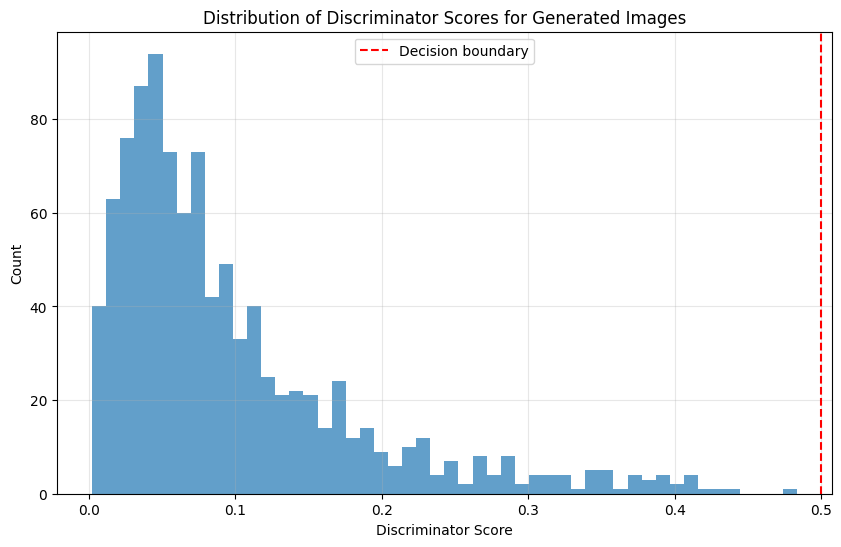

Average discriminator score for real images: 0.9759


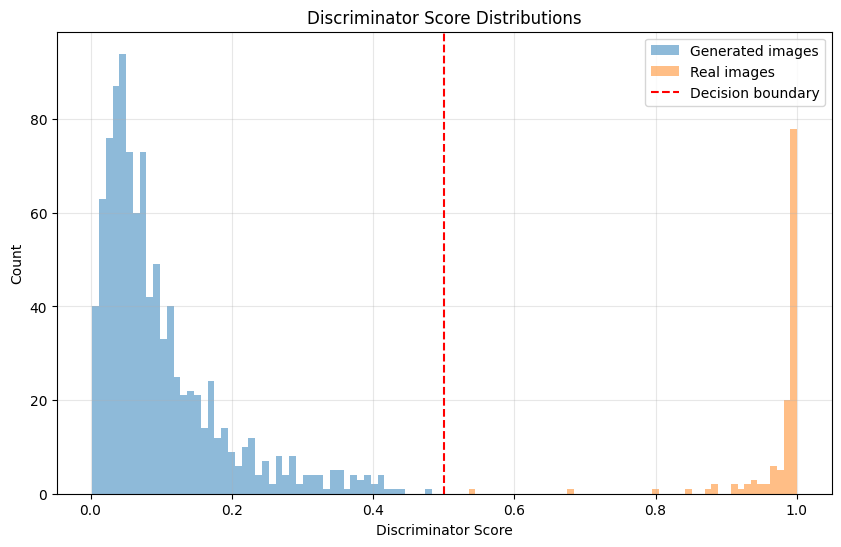

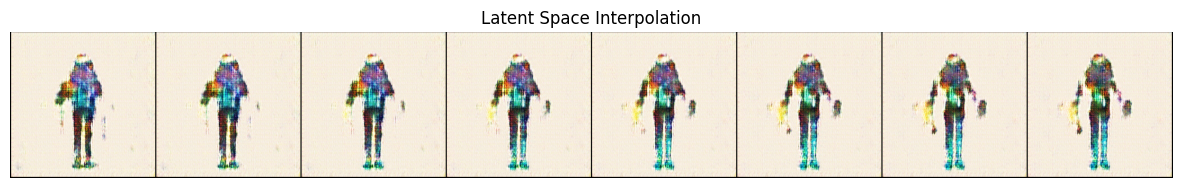

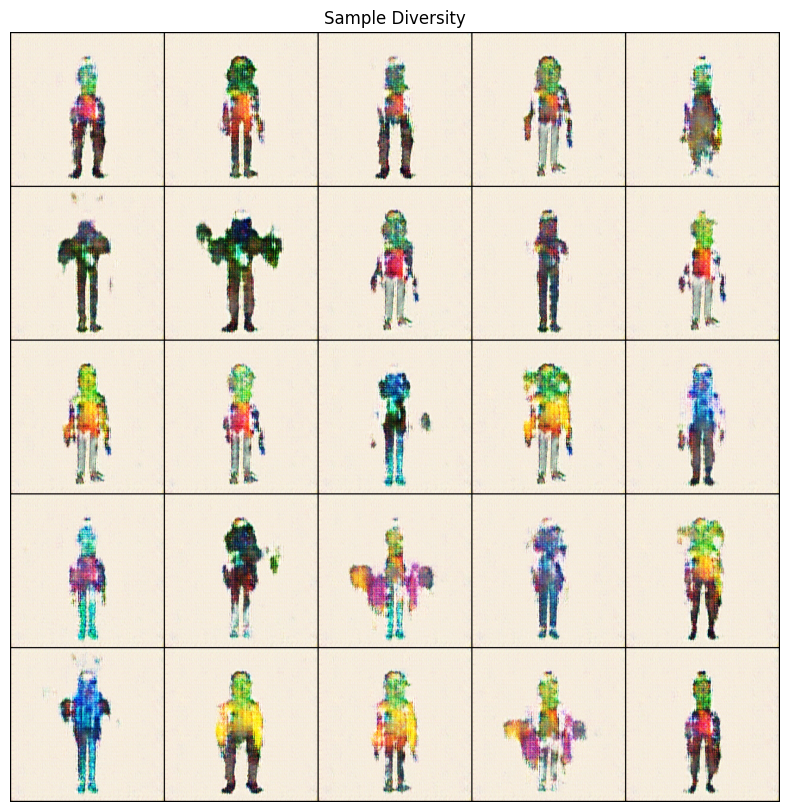


Summary Statistics:
Metric                         Value     
------------------------------ ----------
Generator Fooling Rate (%)     0.00      
Avg. Disc. Score (Fake)        0.0971    
Avg. Disc. Score (Real)        0.9759    
Score Gap (Real-Fake)          0.8788    


In [ ]:
# Measure accuracy of the generator using the discriminator
print("Evaluating GeneratorModel performance...")

# Generate a large batch of images for evaluation
num_test_samples = 1000
test_noise = torch.randn(num_test_samples, gen_input_size, 1, 1, device=device)
with torch.no_grad():
    generated_images = netG(test_noise)

# Get discriminator scores for fake images
disc_scores = discriminator(generated_images).view(-1)
avg_disc_score = disc_scores.mean().item()
print(f"Average discriminator score for fake images: {avg_disc_score:.4f}")

# Calculate how many images "fool" the discriminator
fooling_rate = (disc_scores > 0.5).float().mean().item() * 100
print(f"Percentage of images that 'fool' the discriminator: {fooling_rate:.2f}%")

# Histogram of discriminator scores 
plt.figure(figsize=(10, 6))
plt.hist(disc_scores.detach().cpu().numpy(), bins=50, alpha=0.7)
plt.axvline(x=0.5, color='red', linestyle='--', label='Decision boundary')
plt.xlabel('Discriminator Score')
plt.ylabel('Count')
plt.title('Distribution of Discriminator Scores for Generated Images')
plt.legend()
plt.grid(alpha=0.3)
plt.show()

# Get discriminator scores for real images
init_batch = next(iter(dataloader))
real_images = init_batch[0].to(device)
with torch.no_grad():  # Add no_grad here to prevent gradient tracking
    real_disc_scores = discriminator(real_images).view(-1)
avg_real_disc_score = real_disc_scores.mean().item()
print(f"Average discriminator score for real images: {avg_real_disc_score:.4f}")

# Compare score distributions 
plt.figure(figsize=(10, 6))
plt.hist(disc_scores.detach().cpu().numpy(), bins=50, alpha=0.5, label='Generated images')
plt.hist(real_disc_scores.detach().cpu().numpy(), bins=50, alpha=0.5, label='Real images')
plt.axvline(x=0.5, color='red', linestyle='--', label='Decision boundary')
plt.xlabel('Discriminator Score')
plt.ylabel('Count')
plt.title('Discriminator Score Distributions')
plt.legend()
plt.grid(alpha=0.3)
plt.show()


# Generate a grid of images with gradually changing noise
interpolation_samples = 8
z1 = torch.randn(1, gen_input_size, 1, 1, device=device)
z2 = torch.randn(1, gen_input_size, 1, 1, device=device)

interpolated_images = []
alphas = np.linspace(0, 1, interpolation_samples)

for alpha in alphas:
    z_interp = z1 * (1 - alpha) + z2 * alpha
    with torch.no_grad():
        img = netG(z_interp)
        interpolated_images.append(img.cpu())

# Create a grid of the interpolated images
interpolated_grid = vutils.make_grid(torch.cat(interpolated_images), nrow=interpolation_samples, padding=2, normalize=True)
plt.figure(figsize=(15, 4))
plt.axis("off")
plt.title("Latent Space Interpolation")
plt.imshow(np.transpose(interpolated_grid, (1, 2, 0)))
plt.show()

# Generate multiple images and visualize their diversity
diverse_samples = 25
diverse_noise = torch.randn(diverse_samples, gen_input_size, 1, 1, device=device)
with torch.no_grad():
    diverse_images = netG(diverse_noise)

diverse_grid = vutils.make_grid(diverse_images, nrow=5, padding=2, normalize=True)
plt.figure(figsize=(10, 10))
plt.axis("off")
plt.title("Sample Diversity")
plt.imshow(np.transpose(diverse_grid, (1, 2, 0)))
plt.show()

# Calculate and print summary statistics
print("\nSummary Statistics:")
print(f"{'Metric':<30} {'Value':<10}")
print(f"{'-'*30} {'-'*10}")
print(f"{'Generator Fooling Rate (%)':<30} {fooling_rate:<10.2f}")
print(f"{'Avg. Disc. Score (Fake)':<30} {avg_disc_score:<10.4f}")
print(f"{'Avg. Disc. Score (Real)':<30} {avg_real_disc_score:<10.4f}")
print(f"{'Score Gap (Real-Fake)':<30} {avg_real_disc_score - avg_disc_score:<10.4f}")

In [ ]:
import os
import torchvision.utils as vutils

os.makedirs('real_images', exist_ok=True)

count = 0
for batch in dataloader:
    images = batch[0].to('cpu')
    for img in images:
        vutils.save_image(img, f'real_images/real_{count}.png', normalize=True)
        count += 1
    if count >= 1000:  # Save 1000 images max
        break
    
os.makedirs('generated_images', exist_ok=True)

with torch.no_grad():
    fake_images = netG(sample_noise).detach().cpu()

for i, img in enumerate(fake_images):
    vutils.save_image(img, f'generated_images/fake_{i}.png', normalize=True)



In [ ]:
from pytorch_fid import fid_score

fid_value = fid_score.calculate_fid_given_paths(
    ['real_images', 'generated_images'],
    batch_size=50,
    device='cuda' if torch.cuda.is_available() else 'cpu',
    dims=2048,
)

print(f"FID score: {fid_value}")


# Demonstration of Rick Images Generator with Gradio
We have created a demo that works with the best model that we have obtained earlier, and it basically generate images with the properties you have selected in the input. All images generated are saved in best_ricks folder.

In [ ]:
# Install Gradio
%pip install gradio
import gradio as gr
import torch
import numpy as np
from torchvision import transforms


In [ ]:
model_path = "models/rickGeneratorModelModel.pth"

# Load the trained GeneratorModel model
def load_model():
    # Create the GeneratorModel
    loaded_netG = GeneratorModel(ngpu).to(device)
    # Load the trained parameters
    loaded_netG.load_state_dict(torch.load(model_path))
    loaded_netG.eval()
    return loaded_netG

# Generate images function
def generate_rick_images(num_images, randomness, style_mixing=0.0):
    # Set up the GeneratorModel model
    model = load_model()
    
    # Create latent vectors with adjustable randomness
    noise_factor = randomness * 2  # Scale 0-1 to 0-2 for better control
    z = torch.randn(num_images, gen_input_size, 1, 1, device=device) * noise_factor
    
    # If style mixing is enabled, generate a second batch of noise vectors and mix them
    if style_mixing > 0:
        z2 = torch.randn(num_images, gen_input_size, 1, 1, device=device) * noise_factor
        # Mix the two noise vectors based on the style_mixing parameter
        z = z * (1 - style_mixing) + z2 * style_mixing
    
    # Generate images
    with torch.no_grad():
        fake_images = model(z)
    
    # Convert to numpy and adjust format for display
    images_cpu = fake_images.detach().cpu()
    images_grid = vutils.make_grid(images_cpu, nrow=int(np.sqrt(num_images)), padding=2, normalize=True)
    img_array = np.transpose(images_grid.numpy(), (1, 2, 0))
    
    # Make sure the values are in the right range for displaying
    img_array = (img_array * 255).astype(np.uint8)
    
    return img_array

# Create a Gradio interface for the image GeneratorModel
def create_interface():
    # Define the interface inputs
    with gr.Blocks(title="Rick and Morty Image GeneratorModel") as demo:
        gr.Markdown("## Rick Image GeneratorModel GAN")
        gr.Markdown("Generate realistic Rick images using a trained GAN model")
        
        with gr.Row():
            with gr.Column():
                # Input controls
                num_images = gr.Slider(minimum=1, maximum=25, value=9, step=1, label="Number of Images", info="How many images to generate")
                randomness = gr.Slider(minimum=0.1, maximum=2.0, value=1.0, step=0.1, label="Randomness", info="How random the generated images should be")
                style_mix = gr.Slider(minimum=0, maximum=1.0, value=0.0, step=0.05, label="Style Mixing", info="Mix between two random styles")
                generate_btn = gr.Button("Generate Images")
            
            with gr.Column():
                # Output display
                output_image = gr.Image(label="Generated Rick Images")
        
        # Connect the button to the GeneratorModel function
        generate_btn.click(
            fn=generate_rick_images,
            inputs=[num_images, randomness, style_mix],
            outputs=output_image
        )
        
        # Initial example for display
        gr.Examples(
            [[9, 1.0, 0.0], [16, 0.8, 0.3], [4, 1.5, 0.5]],
            [num_images, randomness, style_mix],
            output_image,
            fn=generate_rick_images,
            cache_examples=True,
            label="Example Configurations"
        )
        
        gr.Markdown("### Advanced Use Tips")
        gr.Markdown("- Increase randomness for more varied features")
        gr.Markdown("- Use style mixing to blend characteristics between different Rick variants")
        gr.Markdown("- Generate multiple images to pick your favorite Rick!")
    
    return demo

# Launch the interactive interface
demo = create_interface()
demo.launch(debug=True, share=True)

# Function to generate and save specific images
def generate_and_save_images(num_images=16, randomness=1.0, style_mix=0.0, save_folder="generated_ricks"):
    # Create folder if it doesn't exist
    import os
    os.makedirs(save_folder, exist_ok=True)
    
    # Set up the GeneratorModel model
    model = load_model()
    
    # Create latent vectors
    noise_factor = randomness * 2
    z = torch.randn(num_images, gen_input_size, 1, 1, device=device) * noise_factor
    
    if style_mix > 0:
        z2 = torch.randn(num_images, gen_input_size, 1, 1, device=device) * noise_factor
        z = z * (1 - style_mix) + z2 * style_mix
    
    # Generate images
    with torch.no_grad():
        fake_images = model(z)
    
    # Convert and save individual images
    transform = transforms.ToPILImage()
    for i, img_tensor in enumerate(fake_images):
        img_normalized = (img_tensor.cpu() + 1) / 2.0  # Normalize from [-1,1] to [0,1]
        img_pil = transform(img_normalized)
        img_pil.save(f"{save_folder}/rick_generated_{i+1}.png")
    
    print(f"Saved {num_images} images to {save_folder}/")
    
    # Display grid of saved images
    grid = vutils.make_grid(fake_images, nrow=int(np.sqrt(num_images)), padding=2, normalize=True)
    plt.figure(figsize=(10, 10))
    plt.axis("off")
    plt.title(f"Generated Rick Images (Randomness={randomness}, Style Mix={style_mix})")
    plt.imshow(np.transpose(grid.cpu(), (1, 2, 0)))
    plt.savefig(f"{save_folder}/rick_grid.png", bbox_inches='tight')
    plt.show()

    return f"Saved images to {save_folder}/"

# Save a batch of your favorite Rick images
generate_and_save_images(num_images=16, randomness=1.2, style_mix=0.3, save_folder="best_ricks")